
## About this project

Analysis about apartments in real state market.

Estadisticos:
* Cantidad total
* Precio promedio
* Precio mediano
* Dispersion(p99, p1, desviacion tipica)

Abiertas por:
* Gran Mendoza(General)
* Departamentos(chacras separado)
* Inmobiliaria
* Tipo de precio (Dolar, Peso, no se sabe)
* Tipo de inmueble (Lote, Departamento, Casa)
* _Rango de interes_

Apartments range size in m2: `[0,40),[40,60),[60,90),[90,)`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import time
import random
import sys
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils.inmoclick_clean_utils import fix_clean_total_area,fix_clean_floor_area, bucketizer

## 1.0- Loading Data

### 1.1- Reading the csv

In [3]:
filename = "data_source/dataframe_apartment.csv"
df = pd.read_csv(filename)
df.head(3).T

,0,1,2
ref_id,inmueble-438-2913,inmueble-11737-62,inmueble-5949-987
neighborhood,F Moyano 1525 Quinta Sección Edificio H,PASO,Victor Fayad
district,Capital,Maipu,Maipu
province,Mendoza,Mendoza,Mendoza
price,US$ 180.000,US$ 47.000,US$ 78.000
currency,US$,US$,US$
amount,180000,47000,78000
url,/438-de-lucia/inmuebles/2913/ficha/departament...,/11737-las-marias-desarrollos-inmobiliarios/in...,/5949-alessandra-mariani/inmuebles/987/ficha/d...
description,Inmobiliaria De Lucia vende Departamento en co...,"SOS INVERSOR Y BUSCÁS UN DESARROLLO EN MAIPÚ, ...",ALESSANDRA MARIANI VENDE\nHermoso Complejo Cer...
totalArea,140,85,100


In [4]:
print(f'Total df size: {len(df)}')
print(f'Unique ref_ids: {len(df.ref_id.unique())}')

Total df size: 2304
Unique ref_ids: 2304


### 1.2- Selecting just Gran Mendoza data

In [5]:
df.district.unique()
print(f"Cantidad total de propiedades originales:{len(df)}")
gran_mendoza_list = ['Godoy Cruz', 'Maipu', 'Lujan de Cuyo', 'Las Heras', 'Capital',
       'Carrodilla', 'Guaymallen', 'Chacras de Coria',
       'Vistalba', 'Mayor Drummond', 'Perdriel', 'La Puntilla']
df = df[df.district.isin(gran_mendoza_list)]
print(f"Cantidad total de propiedades en el Gran Mendoza:{len(df)}")

Cantidad total de propiedades originales:2304
Cantidad total de propiedades en el Gran Mendoza:2290


## 2.0- EDA: Apartments

### 2.1- Composicion por tipo de moneda

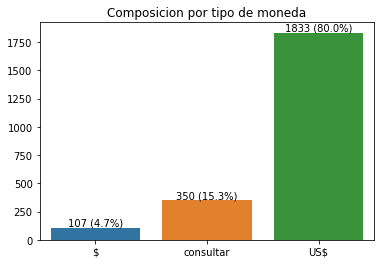

In [6]:
# Fixing nan cases
df.currency = df.currency.fillna('consultar')

curr = df.groupby('currency').count().ref_id.sort_values()
share = round(curr/curr.sum()*100,1)
g = sns.barplot(x=curr.index.values,y=curr.values)
for i,row in enumerate(curr.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i,row[1], bar_text, color='black', ha="center",va='bottom')
    
g.set_title('Composicion por tipo de moneda')
plt.show()

### 2.2- Composicion por distrito

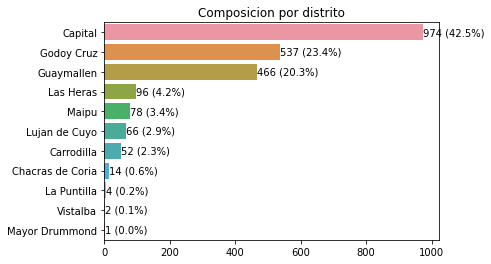

In [7]:
districts = df.groupby('district').count().ref_id.sort_values(ascending=False)
share = round(districts/districts.sum()*100,1)
g = sns.barplot(x=districts.values,y=districts.index.values)

for i,row in enumerate(districts.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por distrito')
plt.show()

### 2.3- Composicion por inmobiliaria

total agencies:215


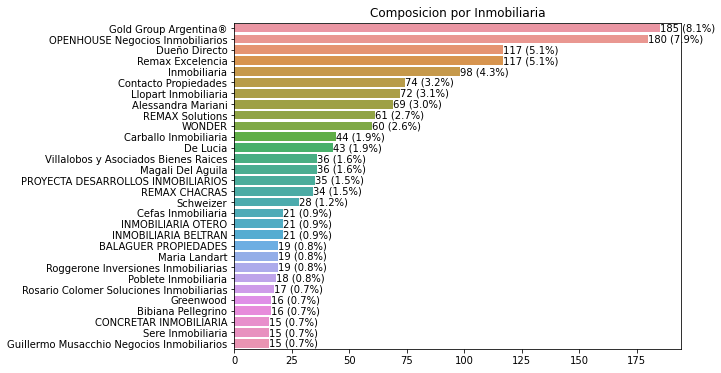

In [8]:
agency = df.groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("total agencies:"+str(len(agency)))

agency = agency.head(30)
plt.figure(figsize=(8,6))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por Inmobiliaria')
plt.show()

### 2.5- floorArea composition
Rango de superficies cubierta para casas en m2:
* 90..120
* 120..240    
* 240..

#### 2.5.1-Percent with disabled floorArea

In [9]:
# Percent of floorArea in disable
100.0 * len(df[df['floorArea']=='disable'])/len(df)

9.344978165938864

#### 2.5.2- Creating buckets with fixed totalArea ranges

In [11]:
# Removing disables
cleaned_df = fix_clean_floor_area(df)
# Avoid apartments with less of 10 square meters
cleaned_df = cleaned_df[cleaned_df.floorArea_fixed >= 10]

# Creating buckets
bucket_separators = [90,120,240]
field = "floorArea_fixed"
new_field="apartment_range"
ranges = bucketizer(cleaned_df, bucket_separators, field, new_field)
ranges

['0..90', '90..120', '120..240', '240..']

#### 2.5.3 Plotting floorArea ranges composition

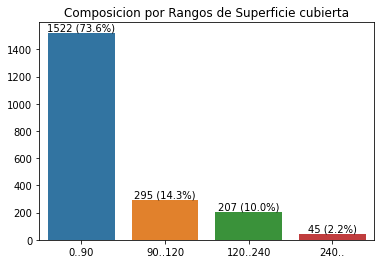

In [12]:
house_range = cleaned_df.groupby('apartment_range').count().ref_id#.sort_values(ascending=False)
share = round(house_range/house_range.sum()*100,1)
g = sns.barplot(x=ranges, y=house_range.values)

for i,row in enumerate(house_range.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i, row[1], bar_text, color='black', ha="center",va='bottom',rotation=0)
g.set_title('Composicion por Rangos de Superficie cubierta')
plt.show()

### 2.6 Apartment size buckets vs district: average squared meter price

#### 2.6.1- Prices without excluding outliers

In [13]:
cleaned_df["squared_meter_price"] = cleaned_df.amount/cleaned_df.floorArea_fixed

pd.pivot_table(cleaned_df[cleaned_df['currency']=='US$'],
               values=['squared_meter_price','ref_id'],
               index='district',
               columns='apartment_range',
               aggfunc={'squared_meter_price':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

#### 2.7.2- Prices excluding outliers

In [14]:
from scipy import stats
dolarized = cleaned_df[cleaned_df['currency']=='US$']
print(f"dolarized with outliers {len(dolarized)}")
z_scores = stats.zscore(dolarized.amount)
abs_z_scores = np.abs(z_scores)
dolarized = dolarized[(abs_z_scores < 3)]

z_scores = stats.zscore(dolarized.floorArea_fixed)
abs_z_scores = np.abs(z_scores)
dolarized = dolarized[(abs_z_scores < 3)]
print(f"dolarized without outliers {len(dolarized)}")

dolarized with outliers 1728
dolarized without outliers 1698


In [16]:
pd.pivot_table(dolarized,
               values=['squared_meter_price','ref_id'],
               index='district',
               columns='apartment_range',
               aggfunc={'squared_meter_price':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

### 3.0- EDA - Extra info

### 3.1 Amount disitribution

<AxesSubplot:>

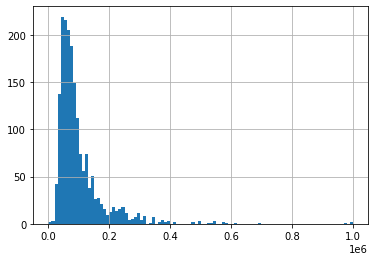

In [19]:
dolarized = df[df.currency=='US$'].copy()
dolarized['truncated_amount'] = dolarized.amount
dolarized.loc[dolarized['amount'] >= 1000000,'truncated_amount']=1000000
dolarized.truncated_amount.hist(bins=100)

### 3.2- Districts distribution

<AxesSubplot:xlabel='district'>

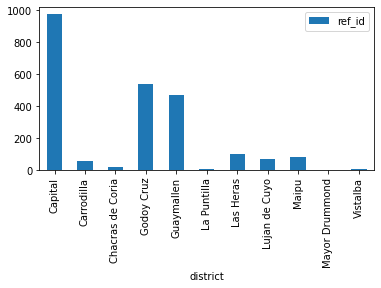

In [22]:
df.groupby('district').count().plot(y='ref_id',kind='bar', figsize=(6,3))

### 3.3- District dolarized rates

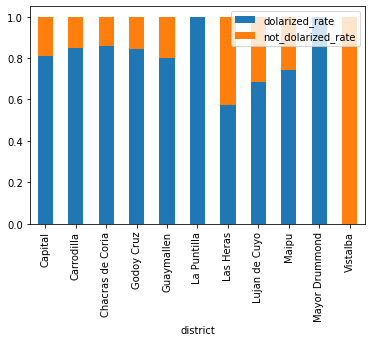

In [21]:
df['dolarized'] = 0
df.loc[df.currency=='US$','dolarized'] = 1
dol_rate = df.groupby('district').agg({'ref_id':'count','dolarized':'sum'}).reset_index()
dol_rate['dolarized_rate']= dol_rate.dolarized/dol_rate.ref_id
dol_rate['not_dolarized_rate']= 1-dol_rate['dolarized_rate']
ax = dol_rate[['district','dolarized_rate','not_dolarized_rate']].plot(x='district', kind='bar', stacked=True)

### 3.2- District vs amount

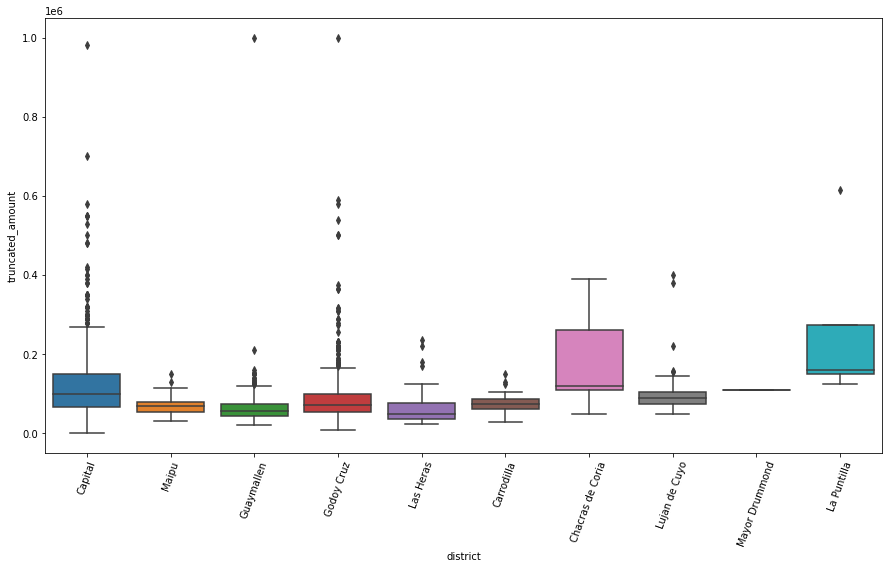

In [23]:
plt.figure(figsize=(15,8))
g = sns.boxplot(x=dolarized['district'], y=dolarized['truncated_amount'])
g.set_xticklabels(g.get_xticklabels(),rotation=70)
plt.show()